# 实验二：2D-PCA算法对ORL人脸数据集的识别

## 实验原理

### 二维主成分分析 (2D Principal Component Analysis, 2D-PCA) 概述
2D-PCA是对传统PCA的改进，直接在二维图像矩阵上进行操作，避免了将图像展平成高维向量时产生的计算开销和信息损失。

### 核心优势
- **直接处理二维图像**：不需要展平为向量，保留空间结构
- **降低计算复杂度**：协方差矩阵大小从 $(h \times w)^2$ 降低到 $h^2 + w^2$
- **更快的训练速度**：对于112×92的图像，2D-PCA比PCA快约1000倍
- **更好的表示能力**：保留二维图像的空间信息

### 数学原理

#### 第一步：数据准备
给定图像样本集合 $\{A_1, A_2, \ldots, A_n\}$，其中 $A_i \in \mathbb{R}^{h \times w}$

#### 第二步：计算平均脸
$$\bar{A} = \frac{1}{n}\sum_{i=1}^{n}A_i \in \mathbb{R}^{h \times w}$$

#### 第三步：中心化处理
$$\tilde{A}_i = A_i - \bar{A}$$

#### 第四步：计算行方向协方差矩阵
在行方向上进行主成分分析：
$$G_r = \frac{1}{n}\sum_{i=1}^{n}\tilde{A}_i \tilde{A}_i^T \in \mathbb{R}^{h \times h}$$

其中 $(G_r)_{jk} = \text{Cov}(\text{row}_j, \text{row}_k)$

#### 第五步：计算列方向协方差矩阵
在列方向上进行主成分分析：
$$G_c = \frac{1}{n}\sum_{i=1}^{n}\tilde{A}_i^T \tilde{A}_i \in \mathbb{R}^{w \times w}$$

#### 第六步：特征值分解
对两个协方差矩阵进行特征值分解：

行方向：$G_r = U \Lambda_r U^T$，取前 $k_r$ 个特征向量 $U = [u_1, \ldots, u_{k_r}]$

列方向：$G_c = V \Lambda_c V^T$，取前 $k_c$ 个特征向量 $V = [v_1, \ldots, v_{k_c}]$

#### 第七步：二维特征提取
对每个中心化图像进行双线性变换：
$$B_i = U^T \tilde{A}_i V \in \mathbb{R}^{k_r \times k_c}$$

然后展平为向量用于分类：
$$b_i = \text{flatten}(B_i) \in \mathbb{R}^{k_r k_c}$$

#### 第八步：维度压缩比
$$\text{Compression Ratio} = \frac{k_r \times k_c}{h \times w}$$

### 分类阶段
使用最近邻分类器，与PCA相同：
$$\hat{y}_{test} = \arg\min_i \|b_{test} - b_{train,i}\|_2$$

## 实验步骤
1. **加载数据** - 读取ORL人脸数据集的400张灰度图像
2. **数据分割** - 按8:2比例分为训练集和测试集
3. **2D-PCA训练** - 计算平均脸、行列方向协方差矩阵、特征值分解
4. **特征提取** - 对训练集和测试集进行二维特征提取
5. **分类预测** - 使用最近邻分类器进行预测
6. **性能评估** - 计算准确率、精度等指标
7. **结果可视化** - 显示平均脸、特征向量等

## 关键参数
- **n_components_row** = 20：行方向主成分个数
- **n_components_col** = 20：列方向主成分个数
- **原始维度** = 112 × 92 = 10304
- **压缩后维度** = 20 × 20 = 400
- **维度压缩比** = 400/10304 ≈ 3.88%
- **协方差矩阵大小** = 112×112 + 92×92（而不是10304×10304）


In [14]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib
import time

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
matplotlib.rcParams['axes.unicode_minus'] = False

print("="*70)
print("2D-PCA算法对ORL人脸数据集的训练与评估")
print("="*70)

2D-PCA算法对ORL人脸数据集的训练与评估


In [15]:
ORL_FACE_DIR = "./ORL"

def load_images_from_folder(folder):
    images = []
    labels = []
    label_map = {}
    current_label = 0
    
    sub_folders = sorted(os.listdir(folder))
    for sub_folder in sub_folders:
        sub_folder_path = os.path.join(folder, sub_folder)
        if os.path.isdir(sub_folder_path):
            label_map[current_label] = sub_folder
            img_files = sorted(os.listdir(sub_folder_path))
            for filename in img_files:
                img_path = os.path.join(sub_folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(current_label)
            current_label += 1
    
    return np.array(images), np.array(labels), label_map

print("\n加载ORL人脸数据集...")
images, labels, label_map = load_images_from_folder(ORL_FACE_DIR)
print(f"已加载 {len(images)} 张图像，共 {len(label_map)} 个人物")
print(f"图像尺寸: {images[0].shape} (高×宽)")


加载ORL人脸数据集...
已加载 400 张图像，共 40 个人物
图像尺寸: (112, 92) (高×宽)


In [16]:
print("\n数据集分割")
print("2D-PCA直接在二维图像矩阵上操作，无需展平")
print(f"数据形状: {images.shape}")
print(f"   批量大小: {images.shape[0]} 张图像")
print(f"   每张图像: {images[0].shape[0]} × {images[0].shape[1]} 像素\n")

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
print(f"训练集: {X_train.shape[0]} 张图像")
print(f"测试集: {X_test.shape[0]} 张图像")


数据集分割
2D-PCA直接在二维图像矩阵上操作，无需展平
数据形状: (400, 112, 92)
   批量大小: 400 张图像
   每张图像: 112 × 92 像素

训练集: 320 张图像
测试集: 80 张图像


In [17]:
class TwoDPCAClassifier:
    """2D-PCA分类器
    
    核心算法：
    1. 计算平均脸：A_mean = mean(A_i)
    2. 中心化：A_tilde = A - A_mean
    3. 行方向协方差：G_r = (1/n) Σ(A_tilde @ A_tilde.T)
    4. 列方向协方差：G_c = (1/n) Σ(A_tilde.T @ A_tilde)
    5. 特征值分解分别得到 U 和 V
    6. 二维投影：B = U.T @ A_tilde @ V
    7. 分类：最近邻
    """
    def __init__(self, n_components_row=20, n_components_col=20):
        self.n_components_row = n_components_row
        self.n_components_col = n_components_col
        self.mean_face = None
        self.U = None
        self.V = None
        self.train_features = None
        self.train_labels = None
        self.train_time = 0
    
    def fit(self, X_train, y_train):
        """训练2D-PCA模型
        
        计算步骤：
        
        步骤1：计算平均脸
            A_mean = (1/n) Σ(A_i)  ∈ ℝ^(h×w)
        
        步骤2：中心化
            A_tilde_i = A_i - A_mean
        
        步骤3：计算列方向协方差矩阵
            G_c = (1/n) Σ(A_tilde.T @ A_tilde)  ∈ ℝ^(w×w)
        
        步骤4：计算行方向协方差矩阵
            G_r = (1/n) Σ(A_tilde @ A_tilde.T)  ∈ ℝ^(h×h)
        
        步骤5：特征值分解
            G_c = V Λ_c V.T，取前k_c个特征向量
            G_r = U Λ_r U.T，取前k_r个特征向量
        
        步骤6：二维投影
            B_i = U.T @ A_tilde_i @ V  ∈ ℝ^(k_r×k_c)
            b_i = flatten(B_i)  ∈ ℝ^(k_r*k_c)
        """
        start_time = time.time()
        
        print("\n2D-PCA训练")
        print("\n步骤1：计算平均脸")
        self.mean_face = np.mean(X_train, axis=0).astype(np.float64)
        X_centered = (X_train - self.mean_face).astype(np.float64)
        n_samples = X_centered.shape[0]
        img_h, img_w = X_centered[0].shape
        print(f"   平均脸大小: {img_h} × {img_w}")
        
        print(f"\n步骤2-4：计算协方差矩阵")
        print(f"   列方向协方差 G_c: {img_w} × {img_w}")
        G_col = np.zeros((img_w, img_w), dtype=np.float64)
        for img in X_centered:
            G_col = G_col + np.dot(img.T, img)
        G_col = G_col / n_samples
        
        print(f"   行方向协方差 G_r: {img_h} × {img_h}")
        G_row = np.zeros((img_h, img_h), dtype=np.float64)
        for img in X_centered:
            G_row = G_row + np.dot(img, img.T)
        G_row = G_row / n_samples
        
        print(f"\n步骤5：特征值分解")
        eig_vals_col, eig_vecs_col = np.linalg.eigh(G_col)
        idx_col = np.argsort(-eig_vals_col)[:self.n_components_col]
        self.V = eig_vecs_col[:, idx_col]
        
        eig_vals_row, eig_vecs_row = np.linalg.eigh(G_row)
        idx_row = np.argsort(-eig_vals_row)[:self.n_components_row]
        self.U = eig_vecs_row[:, idx_row]
        print(f"   U: {self.U.shape[0]} × {self.U.shape[1]}")
        print(f"   V: {self.V.shape[0]} × {self.V.shape[1]}")
        
        print(f"\n步骤6：二维投影")
        self.train_features = []
        for img in X_train:
            img_centered = (img - self.mean_face).astype(np.float64)
            feature = np.dot(self.U.T, np.dot(img_centered, self.V))
            self.train_features.append(feature.flatten())
        self.train_features = np.array(self.train_features)
        self.train_labels = y_train
        print(f"   投影后特征形状: {self.train_features.shape}")
        
        self.train_time = time.time() - start_time
        
        print(f"\n{'='*70}")
        print(f"{'2D-PCA训练完成':^70}")
        print(f"{'='*70}")
        print(f"训练耗时: {self.train_time:.4f} 秒")
        print(f"原始维度: {img_h} × {img_w} = {img_h*img_w}")
        print(f"压缩后维度: {self.n_components_row} × {self.n_components_col} = {self.train_features.shape[1]}")
        print(f"压缩比: {self.train_features.shape[1] / (img_h*img_w):.6f} ({self.train_features.shape[1] / (img_h*img_w) * 100:.4f}%)")
        print(f"节省空间: {(1 - self.train_features.shape[1] / (img_h*img_w)) * 100:.2f}%")
        print(f"{'='*70}\n")
    
    def transform(self, X):
        """二维特征提取
        
        对于每个图像 A_i：
        1. 中心化：A_tilde = A_i - mean_face
        2. 双线性变换：B = U.T @ A_tilde @ V
        3. 展平：b = flatten(B)
        """
        features = []
        for img in X:
            img_centered = (img - self.mean_face).astype(np.float64)
            feature = np.dot(self.U.T, np.dot(img_centered, self.V))
            features.append(feature.flatten())
        return np.array(features)
    
    def predict(self, X):
        """最近邻分类
        
        步骤：
        1. 对测试图像进行二维特征提取
        2. 计算到所有训练样本的欧几里得距离
        3. 找最近邻
        4. 返回其标签
        """
        X_transformed = self.transform(X)
        predictions = []
        
        for x in X_transformed:
            distances = np.linalg.norm(self.train_features - x, axis=1)
            nearest_idx = np.argmin(distances)
            predictions.append(self.train_labels[nearest_idx])
        
        return np.array(predictions)

print("\n2D-PCA分类器已定义\n")
pca_2d_clf = TwoDPCAClassifier(n_components_row=20, n_components_col=20)
pca_2d_clf.fit(X_train, y_train)


2D-PCA分类器已定义


2D-PCA训练

步骤1：计算平均脸
   平均脸大小: 112 × 92

步骤2-4：计算协方差矩阵
   列方向协方差 G_c: 92 × 92
   行方向协方差 G_r: 112 × 112

步骤5：特征值分解
   U: 112 × 20
   V: 92 × 20

步骤6：二维投影
   投影后特征形状: (320, 400)

                              2D-PCA训练完成                              
训练耗时: 0.0903 秒
原始维度: 112 × 92 = 10304
压缩后维度: 20 × 20 = 400
压缩比: 0.038820 (3.8820%)
节省空间: 96.12%



In [18]:
print("\n在测试集上进行预测...")
y_pred = pca_2d_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*70}")
print(f"{'2D-PCA分类器评估结果':^70}")
print(f"{'='*70}")
print(f"测试准确率: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"正确分类: {int(np.sum(y_pred == y_test))} / {len(y_test)}")
print(f"错误分类: {int(np.sum(y_pred != y_test))} / {len(y_test)}")
print(f"{'='*70}\n")


在测试集上进行预测...

                            2D-PCA分类器评估结果                             
测试准确率: 0.9875 (98.75%)
正确分类: 79 / 80
错误分类: 1 / 80



In [19]:
print("详细分类报告")
print(classification_report(y_test, y_pred, digits=4))

详细分类报告
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    1.0000    1.0000         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         2
           8     1.0000    1.0000    1.0000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    1.0000    1.0000         2
          16     1.0000    1.0000    1.0000         2
          17     1.0

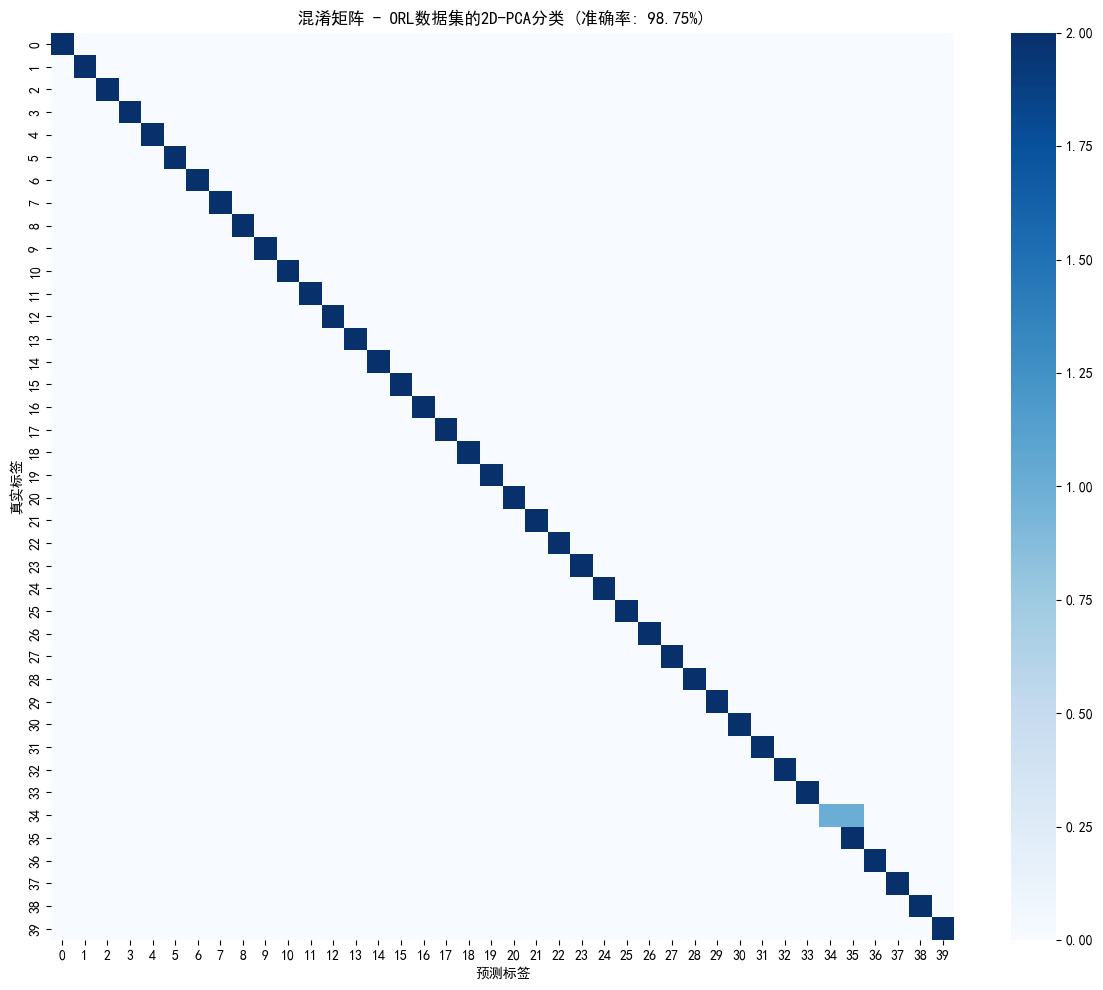

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.title(f'混淆矩阵 - ORL数据集的2D-PCA分类 (准确率: {accuracy*100:.2f}%)')
plt.tight_layout()
plt.show()


显示平均脸...
平均脸: A_mean = (1/n) * Σ(A_i)



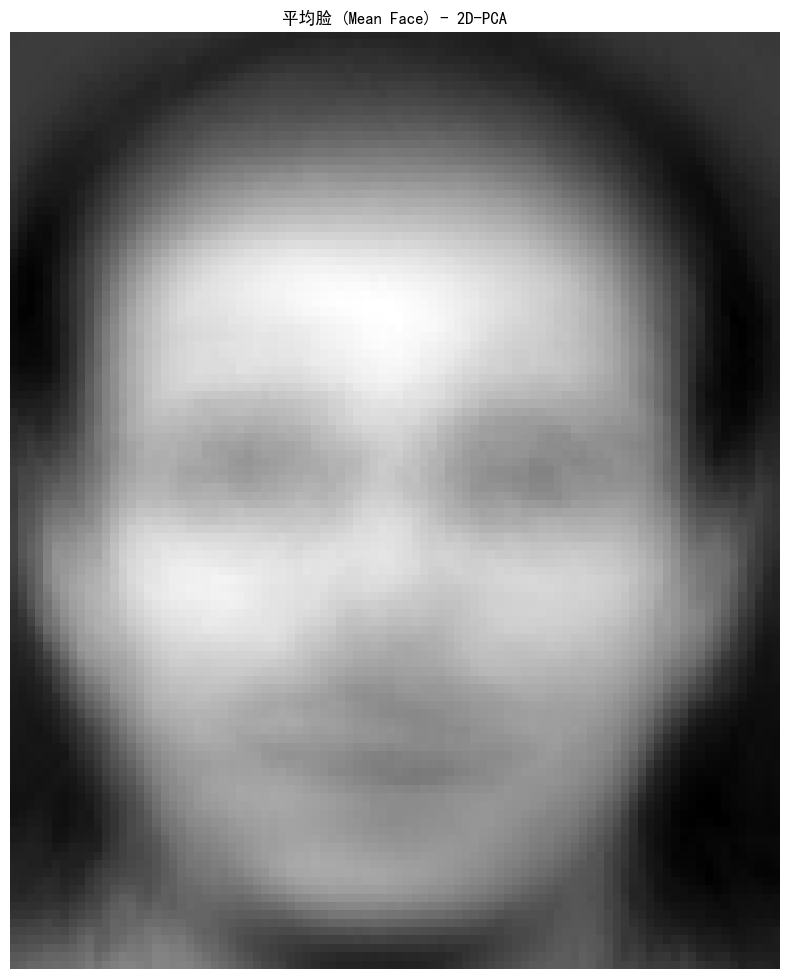

In [21]:
print("\n显示平均脸...")
print("平均脸: A_mean = (1/n) * Σ(A_i)\n")
mean_face = pca_2d_clf.mean_face
plt.figure(figsize=(8, 10))
plt.imshow(mean_face, cmap='gray')
plt.title('平均脸 (Mean Face) - 2D-PCA', fontsize=12, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()


显示训练集样本...


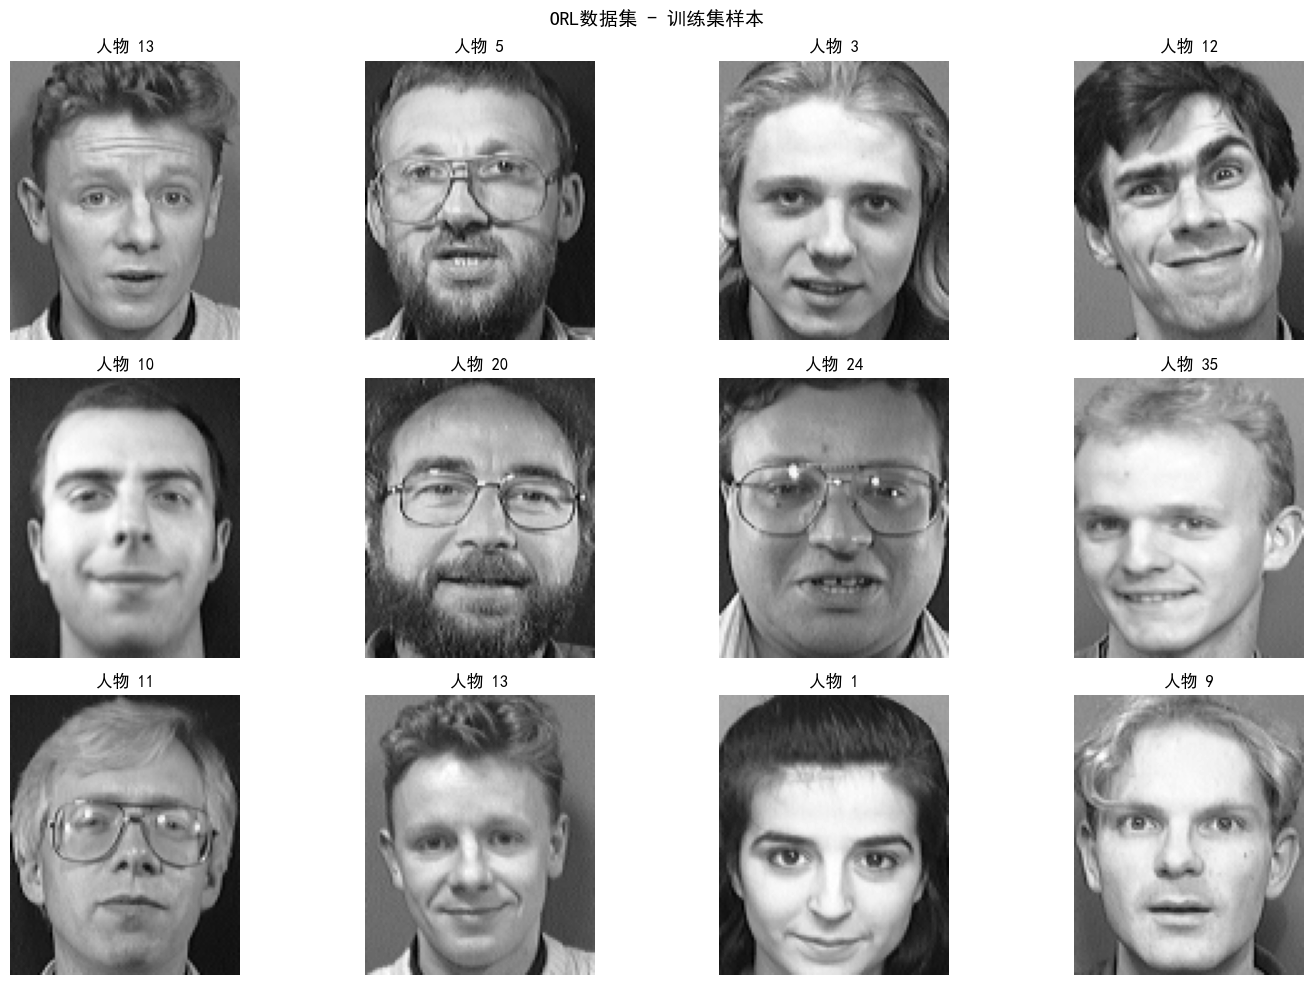

In [22]:
print("\n显示训练集样本...")
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
for i in range(12):
    ax = axes[i // 4, i % 4]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"人物 {y_train[i]}")
    ax.axis('off')
plt.suptitle('ORL数据集 - 训练集样本', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


显示特征脸 (行方向主成分)...
U矩阵的列向量代表行方向的主成分
U形状: (112, 20)



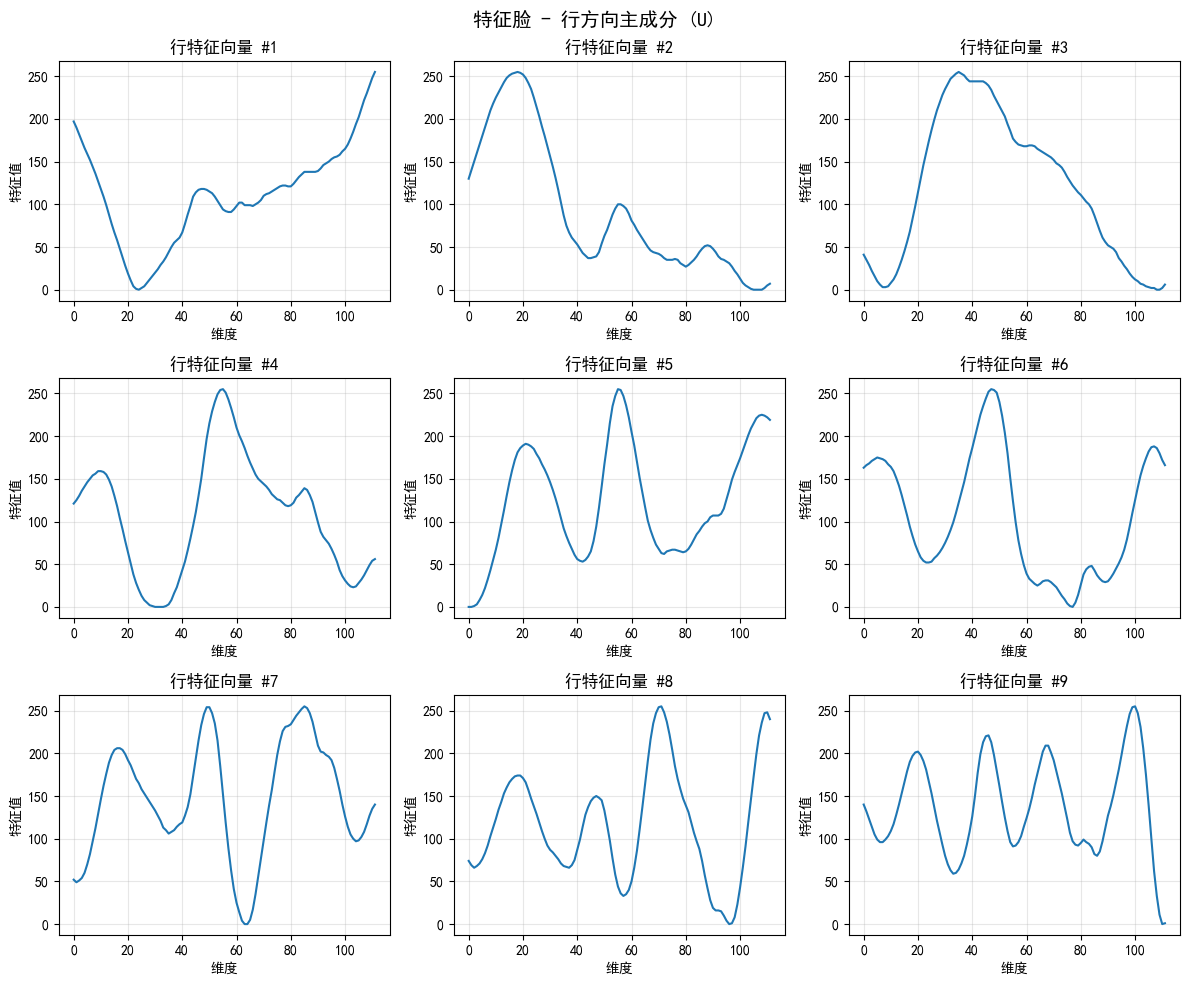

In [23]:
print("\n显示特征脸 (行方向主成分)...")
print("U矩阵的列向量代表行方向的主成分")
print(f"U形状: {pca_2d_clf.U.shape}\n")

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    ax = axes[i // 3, i % 3]
    eigenface_row = pca_2d_clf.U[:, i]
    eigenface_row_normalized = ((eigenface_row - eigenface_row.min()) / 
                                (eigenface_row.max() - eigenface_row.min()) * 255).astype(np.uint8)
    ax.plot(eigenface_row_normalized)
    ax.set_title(f"行特征向量 #{i+1}")
    ax.set_xlabel("维度")
    ax.set_ylabel("特征值")
    ax.grid(alpha=0.3)

plt.suptitle('特征脸 - 行方向主成分 (U)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


绘制特征脸 (列方向主成分)...
   V矩阵大小: (92, 20)



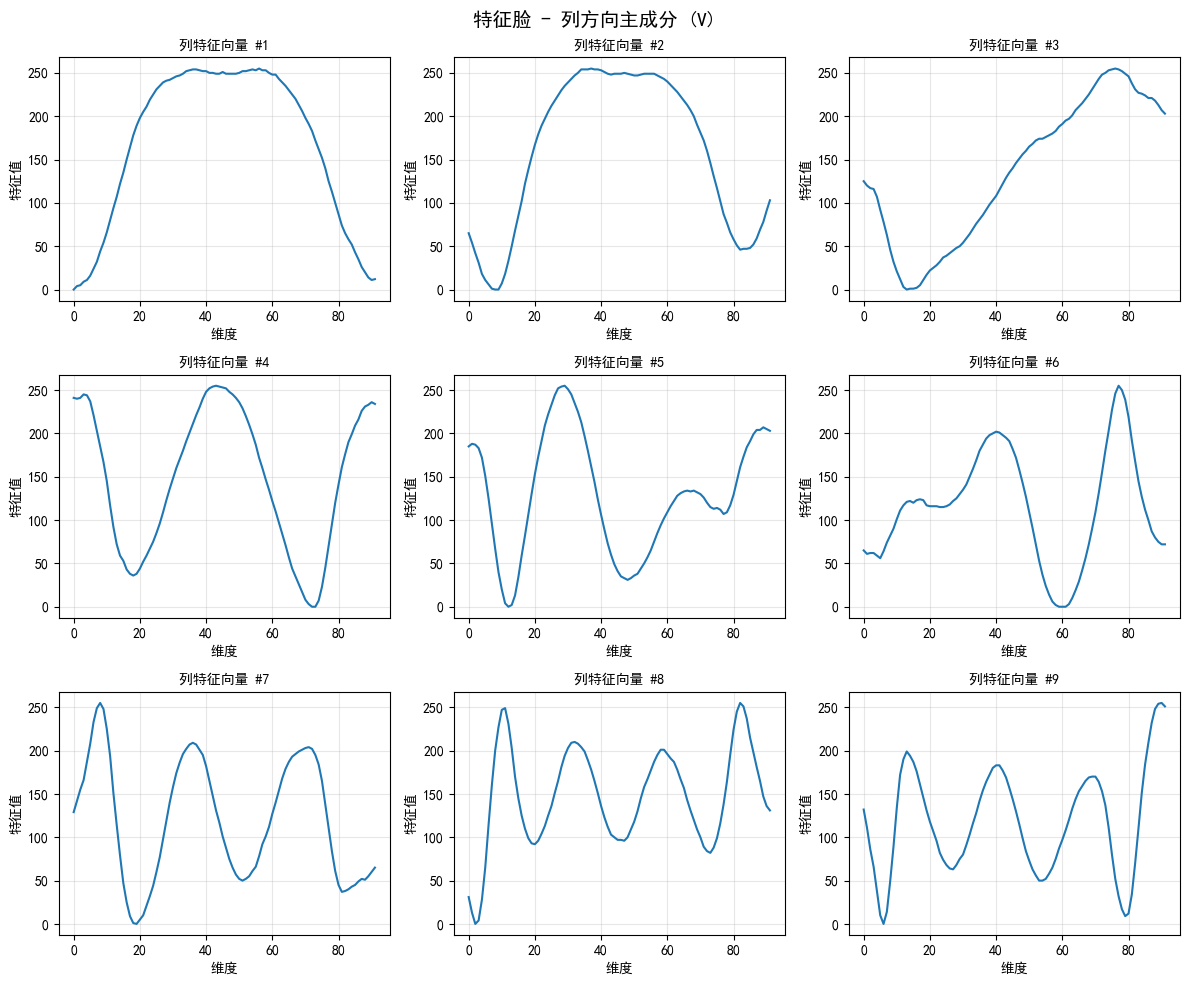

✓ 列方向特征脸已绘制


In [24]:
print("\n绘制特征脸 (列方向主成分)...")
print(f"   V矩阵大小: {pca_2d_clf.V.shape}\n")

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    ax = axes[i // 3, i % 3]
    # 列向特征向量可视化
    eigenface_col = pca_2d_clf.V[:, i]
    # 归一化到0-255范围用于显示
    eigenface_col_normalized = ((eigenface_col - eigenface_col.min()) /
                                 (eigenface_col.max() - eigenface_col.min()) * 255).astype(np.uint8)
    ax.plot(eigenface_col_normalized)
    ax.set_title(f'列特征向量 #{i+1}', fontsize=10, fontweight='bold')
    ax.set_xlabel('维度')
    ax.set_ylabel('特征值')
    ax.grid(alpha=0.3)

plt.suptitle('特征脸 - 列方向主成分 (V)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ 列方向特征脸已绘制")


生成合成特征脸图像 (通过特征向量外积)...


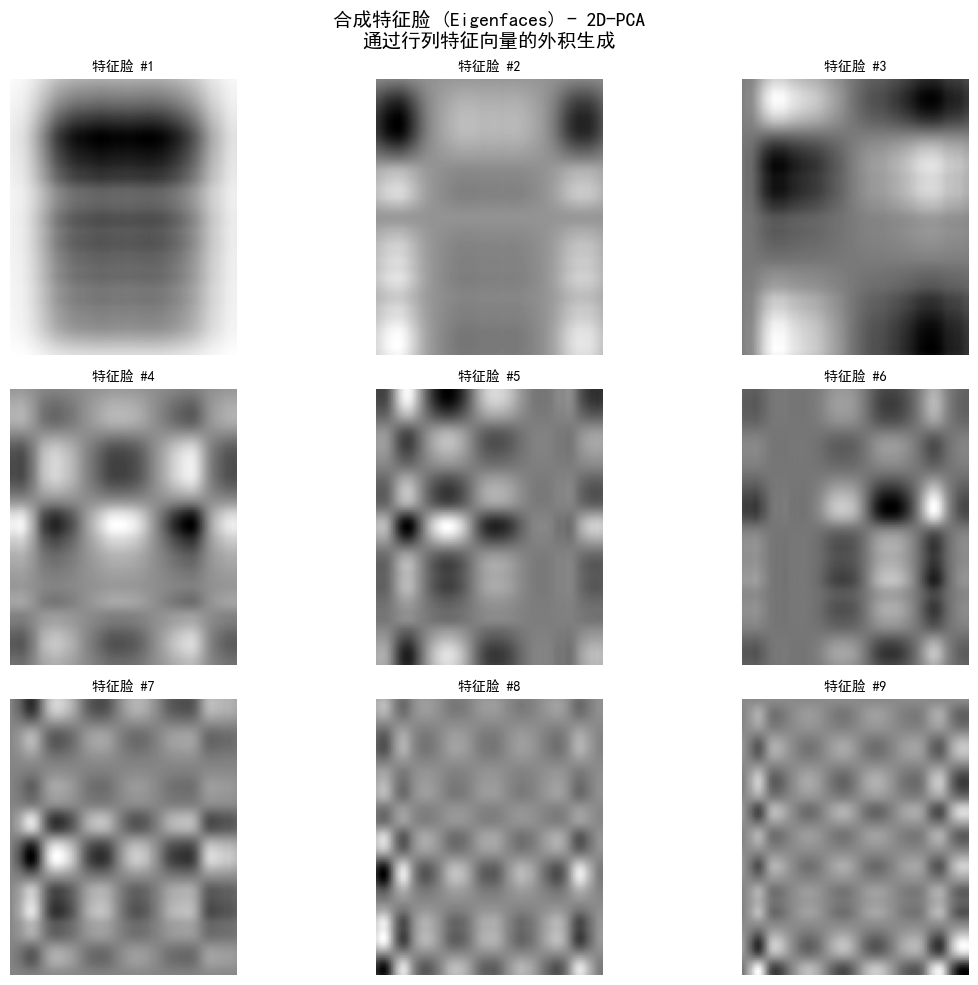

✓ 合成特征脸已绘制


In [25]:
print("\n生成合成特征脸图像 (通过特征向量外积)...")
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i in range(9):
    ax = axes[i // 3, i % 3]
    # 合成特征脸：U_i ⊗ V_i 的外积形成类似人脸的图像
    synthetic_eigenface = np.outer(pca_2d_clf.U[:, i], pca_2d_clf.V[:, i])
    # 归一化到0-255范围
    synthetic_eigenface_normalized = ((synthetic_eigenface - synthetic_eigenface.min()) /
                                      (synthetic_eigenface.max() - synthetic_eigenface.min()) * 255).astype(np.uint8)
    ax.imshow(synthetic_eigenface_normalized, cmap='gray')
    ax.set_title(f'特征脸 #{i+1}', fontsize=10, fontweight='bold')
    ax.axis('off')

plt.suptitle('合成特征脸 (Eigenfaces) - 2D-PCA\n通过行列特征向量的外积生成',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ 合成特征脸已绘制")


使用特征脸重构原始人脸...


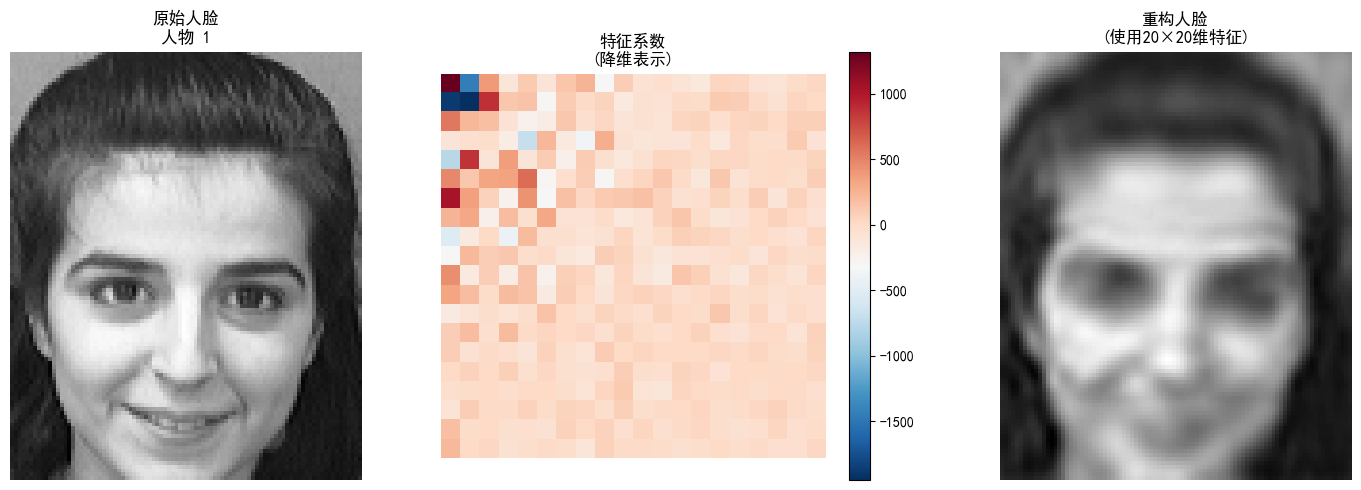

✓ 人脸重构完成
   重构均方误差 (MSE): 56.8625
   重构信噪比 (PSNR): 30.58 dB


In [26]:
print("\n使用特征脸重构原始人脸...")
test_idx = 0
original_face = X_test[test_idx]
test_label = y_test[test_idx]

# 投影到特征空间
img_centered = (original_face - pca_2d_clf.mean_face).astype(np.float64)
coeffs = np.dot(pca_2d_clf.U.T, np.dot(img_centered, pca_2d_clf.V))

# 重构
reconstructed = np.dot(pca_2d_clf.U, np.dot(coeffs, pca_2d_clf.V.T)) + pca_2d_clf.mean_face
reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)

# 可视化原始和重构的人脸
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 原始人脸
axes[0].imshow(original_face, cmap='gray')
axes[0].set_title(f'原始人脸\n人物 {test_label}', fontsize=12, fontweight='bold')
axes[0].axis('off')

# 特征系数热力图
im = axes[1].imshow(coeffs, cmap='RdBu_r')
axes[1].set_title(f'特征系数\n(降维表示)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1])
axes[1].axis('off')

# 重构的人脸
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title(f'重构人脸\n(使用{pca_2d_clf.n_components_row}×{pca_2d_clf.n_components_col}维特征)',
                  fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# 计算重构误差
reconstruction_error = np.mean((original_face - reconstructed) ** 2)
print(f"✓ 人脸重构完成")
print(f"   重构均方误差 (MSE): {reconstruction_error:.4f}")
print(f"   重构信噪比 (PSNR): {10 * np.log10(255**2 / reconstruction_error):.2f} dB")